<a href="https://colab.research.google.com/github/Darkcoder1995/Graph-Neural-Network/blob/main/Building_Recommender_System_Using_GNN_and_PyTorch(LightGCN_Supervised_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [ ]:
!pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.1 MB/s eta 0:00:00


In [ ]:
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

In [ ]:
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"  # Updated URL
extract_zip(download_url(url, '.'), '.')

movie_path = 'ml-latest-small/movies.csv'
rating_path = 'ml-latest-small/ratings.csv'
user_path = 'ml-latest-small/users.csv'

Extracting ./ml-latest-small.zip


'ml-latest-small/users.csv'

In [ ]:
rating_df=pd.read_csv(rating_path)

lbl_user=preprocessing.LabelEncoder()
lbl_movie=preprocessing.LabelEncoder()

rating_df.userId=lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId=lbl_movie.fit_transform(rating_df.movieId.values)

In [ ]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [ ]:
def load_edge_csv(df,src_index_col,dst_index_col,link_index_col,rating_threshold=3.5):
  edge_index=None
  src=[user_id for user_id in df['userId']]

  num_users=len(df['userId'].unique())
  dst=[(movie_id) for movie_id in df['movieId']]
  link_vals=df[link_index_col].values
  edge_attr=torch.from_numpy(df[link_index_col].values).view(-1,1).to(torch.long)>=rating_threshold
  edge_values=[]
  edge_index=[[],[]]

  for i in range(edge_attr.shape[0]):
    if edge_attr[i]:
      edge_index[0].append(src[i])
      edge_index[1].append(dst[i])
      edge_values.append(link_vals[i])

  return edge_index, edge_values

In [ ]:
edge_index, edge_values=load_edge_csv(rating_df,
                                      src_index_col='userId',
                                      dst_index_col='movieId',
                                      link_index_col='rating',
                                      rating_threshold=1)

In [ ]:
edge_index=torch.LongTensor(edge_index)
edge_values=torch.tensor(edge_values)

print(edge_index)
print(edge_index.size())

print(edge_values)
print(edge_values.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])
tensor([4., 4., 4.,  ..., 5., 5., 3.], dtype=torch.float64)
torch.Size([99466])


In [ ]:
num_users=len(rating_df['userId'].unique())
num_movies=len(rating_df['movieId'].unique())

print(f"num_users {num_users}, num_movies {num_movies}")

num_users 610, num_movies 9724


In [ ]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index,input_edge_values):
  R=torch.zeros((num_users,num_movies))
  for i in range(len(input_edge_index[0])):
    row_idx=input_edge_index[0][i]
    col_idx=input_edge_index[1][i]
    R[row_idx][col_idx]=input_edge_values[i]

  R_transpose=torch.transpose(R,0,1)
  adj_mat=torch.zeros((num_users+num_movies,num_users+num_movies))
  adj_mat[:num_users,num_users:]=R.clone()
  adj_mat[num_users:,:num_users]=R_transpose.clone()

  adj_mat_coo=adj_mat.to_sparse_coo()
  adj_mat_coo_indices=adj_mat_coo.indices()
  adj_mat_coo_values=adj_mat_coo.values()
  return adj_mat_coo_indices, adj_mat_coo_values

In [ ]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index,input_edge_values):
  sparse_input_edge_index=SparseTensor(row=input_edge_index[0],
                                       col=input_edge_index[1],
                                       value=input_edge_values,
                                       sparse_sizes=((num_users+num_movies),num_users+num_movies))

  adj_mat=sparse_input_edge_index.to_dense()
  interact_mat=adj_mat[:num_users,num_users:]

  r_mat_edge_index=interact_mat.to_sparse_coo().indices()
  r_mat_edge_values=interact_mat.to_sparse_coo().values()
  return r_mat_edge_index, r_mat_edge_values

In [ ]:
num_interactions=edge_index.shape[1]
all_indices=[i for i in range(num_interactions)]

train_indices, test_indices=train_test_split(all_indices,
                                             test_size=0.2,
                                             random_state=1)

val_indices, test_indices=train_test_split(test_indices,
                                           test_size=0.5,
                                           random_state=1)

In [ ]:
train_edge_index=edge_index[:,train_indices]
train_edge_value=edge_values[train_indices]

val_edge_index=edge_index[:,val_indices]
val_edge_value=edge_values[val_indices]

test_edge_index=edge_index[:,test_indices]
test_edge_value=edge_values[test_indices]

In [ ]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users+num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())
print(test_edge_value)
print(test_edge_value.size())

num_users 610, num_movies 9724, num_interactions 99466
train_edge_index tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9006,  792,  ...,  260, 1486, 3867]])
10334
torch.Size([610])
torch.Size([8898])
tensor([4.5000, 3.5000, 3.5000,  ..., 3.5000, 5.0000, 1.0000],
       dtype=torch.float64)
torch.Size([9947])


In [ ]:
train_edge_index, train_edge_value=convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index,train_edge_value)
val_edge_index, val_edge_value=convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index,val_edge_value)
test_edge_index, test_edge_value=convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index,test_edge_value)

In [ ]:
print(train_edge_index)
print(train_edge_index.size())

print(val_edge_index)
print(val_edge_index.size())

print(test_edge_index)
print(test_edge_index.size())

print(f"\n train_edge_values: \n{train_edge_value} \n {train_edge_value.size()}")
print(f"\n val_edge_values: \n{val_edge_value} \n {val_edge_value.size()}")
print(f"\n test_edge_values: \n{test_edge_value} \n {test_edge_value.size()}")

tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.Size([2, 159144])
tensor([[    0,     0,     0,  ..., 10312, 10316, 10327],
        [  612,   699,   924,  ...,   247,    49,   183]])
torch.Size([2, 19894])
tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])
torch.Size([2, 19894])

 train_edge_values: 
tensor([4.0000, 4.0000, 5.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([159144])

 val_edge_values: 
tensor([4.0000, 5.0000, 4.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([19894])

 test_edge_values: 
tensor([5.0000, 5.0000, 5.0000,  ..., 3.0000, 4.5000, 2.5000]) 
 torch.Size([19894])


In [ ]:
class LightGCN(MessagePassing):
  def __init__(self,num_users,num_items,embedding_dim=64,K=3,add_self_loops=False,dropout_rate=0.2):
    super().__init__()
    self.dropout_rate=dropout_rate
    self.num_users=num_users
    self.num_items=num_items
    self.embedding_dim=embedding_dim
    self.K=K
    self.add_self_loops=add_self_loops

    self.users_emb=nn.Embedding(num_embeddings=self.num_users,
                                embedding_dim=self.embedding_dim)
    self.items_emb=nn.Embedding(num_embeddings=self.num_items,
                                embedding_dim=self.embedding_dim)


    nn.init.normal_(self.users_emb.weight,std=0.1)
    nn.init.normal_(self.items_emb.weight,std=0.1)

    self.out=nn.Linear(embedding_dim + embedding_dim,1)

  def forward(self,edge_index:Tensor,edge_values:Tensor):
    edge_index_norm=gcn_norm(edge_index=edge_index,add_self_loops=self.add_self_loops)
    emb_0=torch.cat([self.users_emb.weight,self.items_emb.weight])
    embs=[emb_0]
    emb_k=emb_0

    for i in range(self.K):
      emb_k=self.propagate(edge_index=edge_index_norm[0],x=emb_k,norm=edge_index_norm[1])
      embs.append(emb_k)

    embs=torch.stack(embs,dim=1)
    emb_final=torch.mean(embs,dim=1)

    users_emb_final,items_emb_final=torch.split(emb_final,[self.num_users,self.num_items])

    r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index,edge_values)

    src, dest=r_mat_edge_index[0],r_mat_edge_index[1]

    users_embeds=users_emb_final[src]
    items_embeds=items_emb_final[dest]

    output=torch.cat([users_embeds,items_embeds],dim=1)
    output=self.out(output)

    return output

  def message(self,x_j,norm):
    return norm.view(-1,1)*x_j

layers=1
model=LightGCN(num_users=num_users,
               num_items=num_movies,
               embedding_dim=64,
               K=layers)

In [ ]:
ITERATIONS=10000
EPOCHS=10
BATCH_SIZE=1024
LR=1e-3
ITERS_PER_EVAL=200
ITERS_PER_LR_DECAY=200
K=10
LAMBDA=1e-6

In [ ]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model=model.to(device)
model.train()

optimizer=optim.Adam(model.parameters(),lr=LR,weight_decay=0.01)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)

edge_index=edge_index.to(device)
train_edg_index=train_edge_index.to(device)
val_edge_index=val_edge_index.to(device)

loss_func=nn.MSELoss()

Using device cpu.


In [ ]:
def get_recall_at_k(input_edge_index,
                    input_edge_values,
                    pred_ratings,
                    k=10,
                    threshold=3.5):
  with torch.no_grad():
    user_item_rating_list=defaultdict(list)

    for i in range(len(input_edge_index[0])):
      src=input_edge_index[0][i].item()
      dest=input_edge_index[1][i].item()
      true_rating=input_edge_values[i].item()
      pred_rating=pred_ratings[i].item()

      user_item_rating_list[src].append((pred_rating,true_rating))

    recalls=dict()
    precisions=dict()

    for user_id, user_ratings in user_item_rating_list.items():
      user_ratings.sort(key=lambda x:x[0],reverse=True)

      n_rel=sum((true_r>=threshold) for (_,true_r) in user_ratings)
      n_rec_k=sum((est>=threshold) for (est,_ ) in user_ratings[:k])

      n_rel_and_rec_k=sum(
          ((true_r>=threshold) and (est>=threshold))
          for (est,true_r) in user_ratings[:k]
      )

      precisions[user_id]=n_rel_and_rec_k/n_rec_k if n_rec_k !=0 else 0
      recalls[user_id]=n_rel_and_rec_k/n_rel if n_rel!=0 else 0

    overall_recall=sum(rec for rec in recalls.values())/len(recalls)
    overall_precision=sum(prec for prec in precisions.values())/len(precisions)

    return overall_recall, overall_precision

In [ ]:
r_mat_train_edge_index, r_mat_train_edge_values=convert_adj_mat_edge_index_to_r_mat_edge_index(train_edge_index,train_edge_value)
r_mat_val_edge_index, r_mat_val_edge_values=convert_adj_mat_edge_index_to_r_mat_edge_index(val_edge_index,val_edge_value)
r_mat_test_edge_index, r_mat_test_edge_values=convert_adj_mat_edge_index_to_r_mat_edge_index(test_edge_index,test_edge_value)

In [ ]:
train_losses=[]
val_losses=[]
val_recall_at_ks=[]

for iter in tqdm(range(ITERATIONS)):
  pred_ratings=model.forward(train_edge_index,train_edge_value)
  train_loss=loss_func(pred_ratings,r_mat_train_edge_values.view(-1,1))
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if iter%ITERS_PER_EVAL==0:
    model.eval()

    with torch.no_grad():
      val_pred_ratings=model.forward(val_edge_index,val_edge_value)
      val_loss=loss_func(val_pred_ratings,r_mat_val_edge_values.view(-1,1)).sum()
      recall_at_k,precision_at_k=get_recall_at_k(r_mat_val_edge_index,
                                               r_mat_val_edge_values,
                                               val_pred_ratings,
                                               k=20)

      val_recall_at_ks.append(round(recall_at_k,5))
      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())

      print(f"[Iteration {iter}/{ITERATIONS}], train_loss:{round(train_loss.item(),5)}, val_loss:{round(val_loss.item(),5)}, recall_at_k:{round(recall_at_k,5)}, precision_at_k:{round(precision_at_k,5)}")

    model.train()

  if iter%ITERS_PER_LR_DECAY==0 and iter!=0:
    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000], train_loss:13.07533, val_loss:13.05067, recall_at_k:0.0, precision_at_k:0.0
[Iteration 200/10000], train_loss:2.37509, val_loss:2.48713, recall_at_k:0.01038, precision_at_k:0.10885
[Iteration 400/10000], train_loss:1.51803, val_loss:1.58884, recall_at_k:0.07157, precision_at_k:0.29565
[Iteration 600/10000], train_loss:1.28169, val_loss:1.34514, recall_at_k:0.1142, precision_at_k:0.36739
[Iteration 800/10000], train_loss:1.16174, val_loss:1.22154, recall_at_k:0.14509, precision_at_k:0.41523
[Iteration 1000/10000], train_loss:1.08594, val_loss:1.14359, recall_at_k:0.16977, precision_at_k:0.44399
[Iteration 1200/10000], train_loss:1.0325, val_loss:1.0888, recall_at_k:0.18739, precision_at_k:0.46322
[Iteration 1400/10000], train_loss:0.99228, val_loss:1.04765, recall_at_k:0.20452, precision_at_k:0.48545
[Iteration 1600/10000], train_loss:0.96066, val_loss:1.01534, recall_at_k:0.21769, precision_at_k:0.49353
[Iteration 1800/10000], train_loss:0.93505, val_loss:0.98912, 

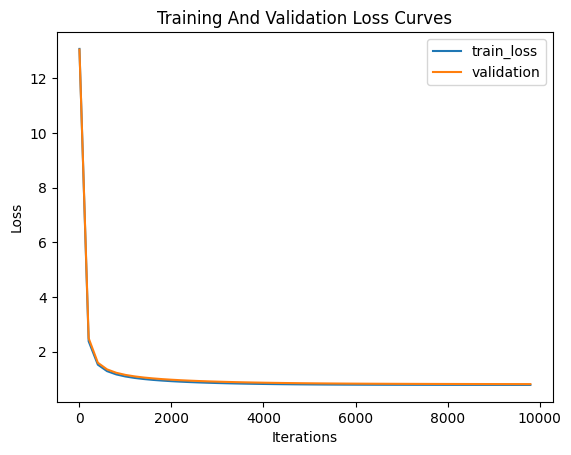

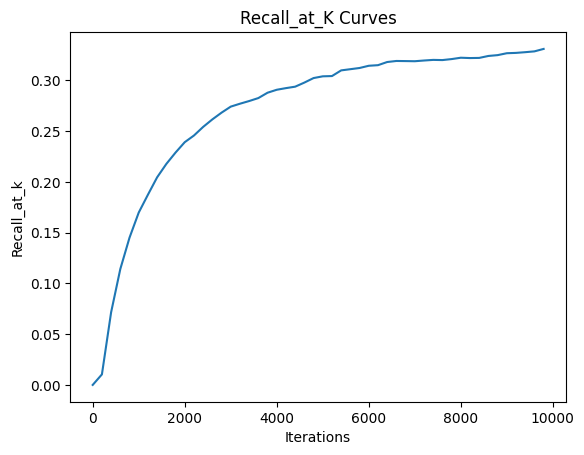

In [ ]:
# iters={iter * ITERS_PER_EVAL for iter in range(len(train_losses))} # Original line
iters=[iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters,train_losses,label='train_loss')
plt.plot(iters,val_losses,label='validation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training And Validation Loss Curves')
plt.legend()
plt.show()

f2=plt.figure()
plt.plot(iters,val_recall_at_ks,label='recall_at_k')
plt.xlabel('Iterations')
plt.ylabel('Recall_at_k')
plt.title('Recall_at_K Curves')
plt.show()

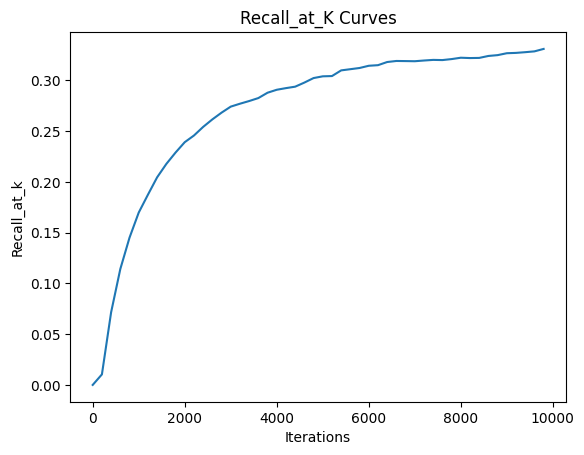

In [ ]:
f2=plt.figure()
plt.plot(iters,val_recall_at_ks,label='recall_at_k')
plt.xlabel('Iterations')
plt.ylabel('Recall_at_k')
plt.title('Recall_at_K Curves')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  pred_ratings=model.forward(test_edge_index,test_edge_value)
  recall_at_k,precision_at_k=get_recall_at_k(r_mat_test_edge_index,
                                            r_mat_test_edge_values,
                                            pred_ratings,20)
  print(f"recall_at_k:{round(recall_at_k,5)}, precision_at_k:{round(precision_at_k,5)}")

recall_at_k:0.33667, precision_at_k:0.55942
